<a href="https://colab.research.google.com/github/alitootoonchian/FinTech/blob/master/PredictStockRNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%tensorflow_version 1.x

In [3]:
#import packages
from IPython.display import display
import pandas as pd
import numpy as np

import datetime as dt
import pandas_datareader.data  as pdr

import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
%matplotlib inline

#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [12, 6]

register_matplotlib_converters()

Using TensorFlow backend.


In [0]:
training_days = 60
total_years = 10
total_dates = total_years * 365
training_itmes = (int)(total_years * 252 * 0.7)
all_model_objects = {}

In [0]:
def build_price_model(ticker, data, training_days, training_itmes, n_days):
  if all_model_objects.get(ticker) != None:
    if all_model_objects.get(ticker).get(n_days) != None:
      return all_model_objects.get(ticker).get(n_days)
  else:
    all_model_objects[ticker] = {}

  features = ['High', 'Low', 'Close']
  price_close_dataset = data['Adj Close'].values.reshape(-1, 1)
  price_high_dataset = data['High'].values.reshape(-1, 1)
  price_low_dataset = data['Low'].values.reshape(-1, 1)

  #converting price_dataset and volume_dataset into x_train and y_train
  price_scaler = MinMaxScaler(feature_range=(0, 1))
  scaled_close_price = price_scaler.fit_transform(price_close_dataset)
  scaled_high_price = price_scaler.transform(price_high_dataset)
  scaled_low_price = price_scaler.transform(price_low_dataset)

  x_train , y_train = [], []
  for i in range(training_days, training_itmes - n_days):
      x_train.append(scaled_close_price[i - training_days:i, 0])
      #x_train.append(
      #    np.concatenate((
      #      scaled_close_price[i - training_days:i, 0],
      #      scaled_high_price[i - training_days:i, 0],
      #      scaled_low_price[i - training_days:i, 0]
      #      )))
          
      y_train.append(scaled_close_price[i + n_days, 0])

  x_train, y_train = np.array(x_train), np.array(y_train)

  x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

  # create and fit the LSTM network
  model = Sequential()
  model.add(LSTM(units=50, 
                 return_sequences=True, input_shape=(x_train.shape[1],1)))
  #model.add(Dropout(0.2))

  #model.add(LSTM(units = 50, return_sequences = True))
  #model.add(Dropout(0.2))

  #model.add(LSTM(units = 50, return_sequences = True))
  #model.add(Dropout(0.2))

  model.add(LSTM(units = 50, return_sequences=False))
  #model.add(Dropout(0.2))
  model.add(Dense(25))
  model.add(Dense(1))

  model.compile(loss='mean_squared_error', optimizer='adam')
  model.fit(x_train, y_train, epochs=3, batch_size=1, verbose=2)

  all_model_objects[ticker][n_days] = [model, price_scaler]
  return [model, price_scaler]

def predict_price(data, training_days, training_itmes, model, price_scaler):
  valid_price_close = data[training_itmes - training_days:]['Adj Close']
  valid_price_close = valid_price_close.values.reshape(-1, 1)
  valid_price_close = price_scaler.transform(valid_price_close)

  valid_price_high = data[training_itmes - training_days:]['High']
  valid_price_high = valid_price_high.values.reshape(-1, 1)
  valid_price_high = price_scaler.transform(valid_price_high)

  valid_price_low = data[training_itmes - training_days:]['High']
  valid_price_low = valid_price_low.values.reshape(-1, 1)
  valid_price_low = price_scaler.transform(valid_price_low)

  X_test = []
  for i in range(training_days, valid_price_close.shape[0]):
      X_test.append(valid_price_close[i - training_days:i, 0])
      #X_test.append(
      #    np.concatenate((
      #      valid_price_close[i - training_days:i, 0],
      #      valid_price_high[i - training_days:i, 0],
      #      valid_price_low[i - training_days:i, 0]
      #      )))
  X_test = np.array(X_test)

  valid_price_close = data[training_itmes - training_days:]['Adj Close'].values.reshape(-1, 1)

  X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
  closing_price = model.predict(X_test)
  closing_price = price_scaler.inverse_transform(closing_price)

  rms = np.sqrt(np.mean(np.power((valid_price_close[:, 0] - closing_price),2)))
  print("RMSE:{}".format(rms))
  return closing_price 

def make_prediction_data(data, closing_price, n_days, start_date, end_date):
  prediction = data.copy()
  prediction = prediction.dropna()
  prediction.loc[-closing_price.shape[0]:, 'Predictions'] = closing_price[:,0]
  prediction = prediction.drop(["High", "Low", "Open", "Close", "Volume"], axis=1)
  prediction = prediction[start_date:end_date]
  prediction['NextPrice'] = prediction['Adj Close'].shift(n_days)
  prediction = prediction.dropna()
  prediction['Ret'] = (prediction['Adj Close'] - prediction['NextPrice']) / prediction['Adj Close']
  prediction['AbsRet'] = prediction.apply(lambda r: abs(r['Ret']), axis=1)
  prediction['RetPred'] = (prediction['Adj Close'] - prediction['Predictions']) / prediction['Adj Close']
  prediction['Correct'] = prediction.apply (lambda row: -1 if (row['Ret'] * row['RetPred'] < 0) else 1, axis=1)
  
  success_prediction = prediction[prediction.Correct == 1].shape[0] / prediction.shape[0]
  avg_ret = prediction['AbsRet'].mean()
  profit = (success_prediction * avg_ret) - (1 - success_prediction) * 0.01
  yearly_profit = (1 + profit) ** 252

  beta, alpha = np.polyfit(prediction['Ret'], prediction['RetPred'], 1)

  print("success_prediction = {:.3f}". format(success_prediction))
  print("        avg_return = {:.3f}". format(avg_ret))
  print("            profit = {:.3f}". format(profit))
  print("     yearly_profit = {:2.3f}". format(yearly_profit))
  print (" beta = {:.3f}". format(beta))
  print ("alpha = {:.3f}". format(alpha))

  plt.plot(prediction[['NextPrice', 'Predictions']])
  plt.show()
  print ("")
  plt.scatter(x=prediction['Ret'], y=prediction['RetPred'])

  plt.plot(prediction['Ret'], prediction['Ret'] * beta + alpha, '-', c='r' )

  plt.show()
  return prediction

In [0]:
ticker = 'AAPL'
n_days = 3
data = pdr.get_data_yahoo(ticker, dt.date.today() - dt.timedelta(total_dates), dt.date.today())
model_objects = build_price_model(ticker, data, training_days, training_itmes, n_days)
model = model_objects[0]
price_scaler = model_objects[1]

In [0]:
closing_price = predict_price(data, training_days, training_itmes, model, price_scaler)
predictions = make_prediction_data(data, closing_price, n_days)

In [0]:
ticker = "GOOG"
n_days = 7
data = pdr.get_data_yahoo(ticker, dt.date.today() - dt.timedelta(total_dates), dt.date.today())
model_objects = build_price_model(ticker, data, training_days, training_itmes, n_days)
closing_price = predict_price(data, training_days, training_itmes, model_objects[0], model_objects[1])
predictions = make_prediction_data(data, closing_price, n_days)

In [0]:
closing_price = predict_price(data, training_days, training_itmes, model, price_scaler)


In [0]:
ticker = "IBM"
end_date = dt.date.today()
start_date = end_date - dt.timedelta(total_dates)
data = pdr.get_data_yahoo(ticker, start_date, end_date)
n_days = 1
model_objects = build_price_model(data, training_days, training_itmes, n_days)
model = model_objects[0]
price_scaler = model_objects[1]

In [0]:
closing_price = predict_price(data, training_days, training_itmes, model, price_scaler)
predictions = make_prediction_data(data, closing_price, n_days)

In [0]:
ticker = "MSFT"
end_date = dt.date.today()
start_date = end_date - dt.timedelta(total_dates)
data = pdr.get_data_yahoo(ticker, start_date, end_date)
n_days = 3
model_objects = build_price_model(data, training_days, training_itmes, n_days)
model = model_objects[0]
price_scaler = model_objects[1]

In [0]:
closing_price = predict_price(data, training_days, training_itmes, model, price_scaler)
predictions = make_prediction_data(data, closing_price, n_days)

RMSE:209.77476865142245
success_prediction = 0.879
        avg_return = 0.020
            profit = 0.016
     yearly_profit = 58.104
 beta = 0.803
alpha = -0.001


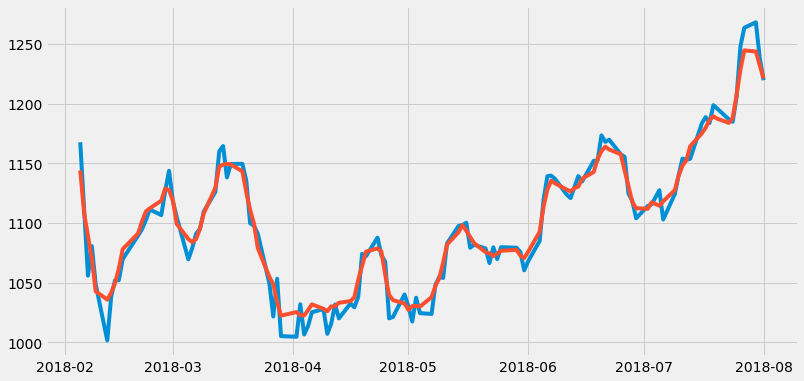

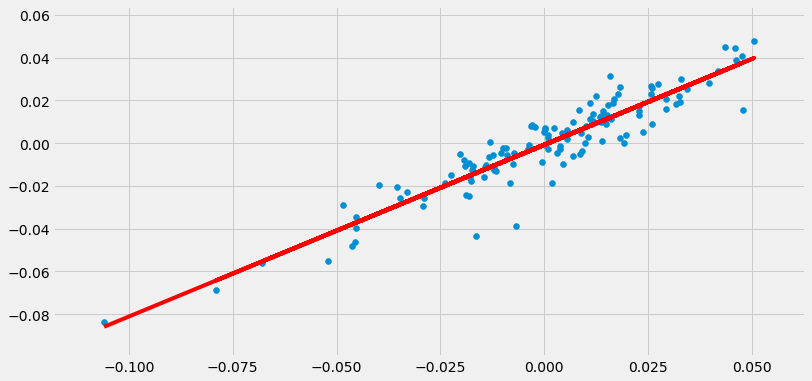

In [30]:
#@title Parameters
ticker = 'GOOG' #@param ["GOOG", "IBM", "MSFT", "AAPL"]
predict_days = "2" #@param [1, 2, 3, 7]
start_date = '2018-02-01' #@param {type:"date"}
end_date = '2018-08-01' #@param {type:"date"}
n_days = int(predict_days)
data = pdr.get_data_yahoo(ticker, dt.date.today() - dt.timedelta(total_dates), dt.date.today())
model_objects = build_price_model(ticker, data, training_days, training_itmes, n_days)
closing_price = predict_price(data, training_days, training_itmes, model_objects[0], model_objects[1])
predictions = make_prediction_data(data, closing_price, n_days, start_date, end_date)